# An Image is worth 16x16 words paper implementation & explanation - from scratch
by Sham Zain
**source** : https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

In [2]:
import numpy as np
from tqdm import tqdm, trange
import torch
import torch.nn as nn

from IPython.display import Image

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST


np.random.seed(0)
torch.manual_seed(0)

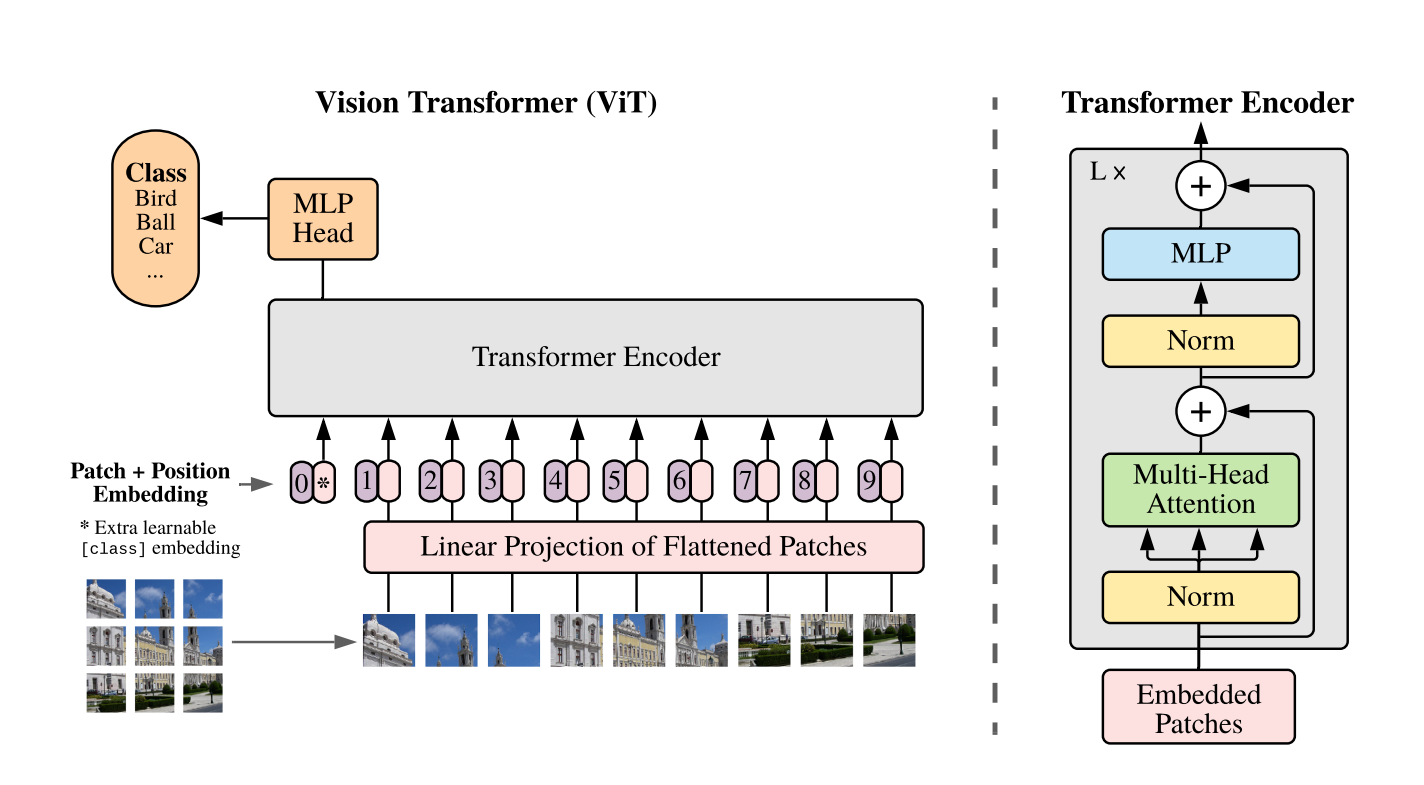

In [3]:
Image("ViT-arch.png", width = 600)

## Main function

-> prepares the dataset and instantiates a model to train for 5 epochs, then loss and accuracy are measured on the test set

device: This line checks if a GPU (CUDA) is available and sets the device accordingly. If no GPU is available, it defaults to using the CPU.

torch.cuda.get_device_name(): If a GPU is detected, this will print the name of the GPU being used.

MyViT: This is the custom Vision Transformer model. 

It takes the input image size (28x28), splits the image into 7x7 patches, uses a hidden dimension of size 8, 2 attention heads, and outputs 10 classes (one for each digit 0-9).


.to(device): Moves the model to the appropriate device (either GPU or CPU).


**training loop**

Outer loop (for epoch in trange(N_EPOCHS, desc="Training")): This loop runs for a number of epochs, which is set to 5 in this case.

For each epoch, the model will go through the entire training dataset.

Inner loop (for batch in tqdm(train_loader)): This loop iterates over the dataset in batches, where each batch contains 128 samples.

x, y = batch: Here, x is the input image (a batch of 128 images), and y is the target label (the digit label for each image).

Moving data to the device: x, y = x.to(device), y.to(device) moves the data to the GPU (if available).

Model Forward Pass (y_hat = model(x)): The input image x is passed through the model to make predictions (y_hat).

Loss Calculation: loss = criterion(y_hat, y) calculates the error (loss) between the predicted values (y_hat) and the actual labels (y).

Backpropagation:

optimizer.zero_grad() clears the gradients from the previous step.

loss.backward() computes the gradients (the derivatives of the loss with respect to the model’s parameters).

optimizer.step() updates the model's weights based on the gradients.

**test loop**

torch.no_grad(): This disables gradient computation, as we don’t need it during inference (testing). It saves memory and speeds up computation.

Testing loop: This loop tests the model on the test set. It calculates the loss and checks how many predictions (y_hat) match the ground truth (y).

torch.argmax(y_hat, dim=1) gets the index of the highest probability (the predicted class).

torch.sum(torch.argmax(y_hat, dim=1) == y) counts the number of correct predictions.

In [ ]:
def main():

    transform = ToTensor()

    train_set = MNIST(root='./../datasets', train = True, download = True, transform = transform)
    test_set = MIST(root='./../datasets', train = False, download = True, transform = transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size= 128)
    test_loader = DataLoader(test_set,shuffle=False, batch_size = 128)

    #define model and training options
    device = torch.device("cude" if torch.cude.is_available else "cpu")
    print( "using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1,28,28), n_patches = 7, hidden_d=8, n_heads=2, out_d=10).to(device)

    N_EPOCHS = 5
    LR = 0.005


    #training loop
    optimizer = Adam(model.parameter(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc = f"Epoch {epoch + 1} in training", leave = False):
            x,y = batch
            x,y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss : {train_loss:.2f}")


    #test loop

    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc= "Training"):
            x,y = batch
            x,y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)

    print(f"Test loss : {test_loss:.2f}")
    print(f"Test accuracy : {correct/total * 100:.2f}%")
    
    
    

# Defining the ViT module

1- Linear Mapper 
-> this function is to be called in the forward function as tokens.
since we have our flat patches, we can map each of them in a linear mapping.
since it can map to any arbitrary size, we add a parameter hidden.nn for the hidden dimension

2- Classification Token
to interpret the V-class in the image, we use the classification token; its a special token we add that has the role of capturing information about the other tokens, then we can use it to classify the image.
The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.
It is also set as the first token to each sequence

3- Position Embedding
code for it is later in the script
We define the positional embedding to be a parameter of our model (that we won’t update by setting its requires_grad to False).



In [12]:
class MyViT(nn.Module):
    def __init__(self):
        super(MyVit,self).__init__()

        #attributes
        self.chw = chw
        self.n_patches = n_patches

        assert chw[1] % n_patches == 0, "input shape not entirely divisible by number"
        assert chw[2] % n_patches == 0
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches )
        
        #1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        #2) Classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))


        #3) Positional embedding
        self.pos_emb = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
        sekf.pos_emb.requires.grad = False
    
    
    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches) 

        #add class token to tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

        #adding position to tokens
        pos_embed = self.pos_embed.repeat(n, 1, 1)
        out = tokens + pos_embed
        return out
                              
        return patches
        

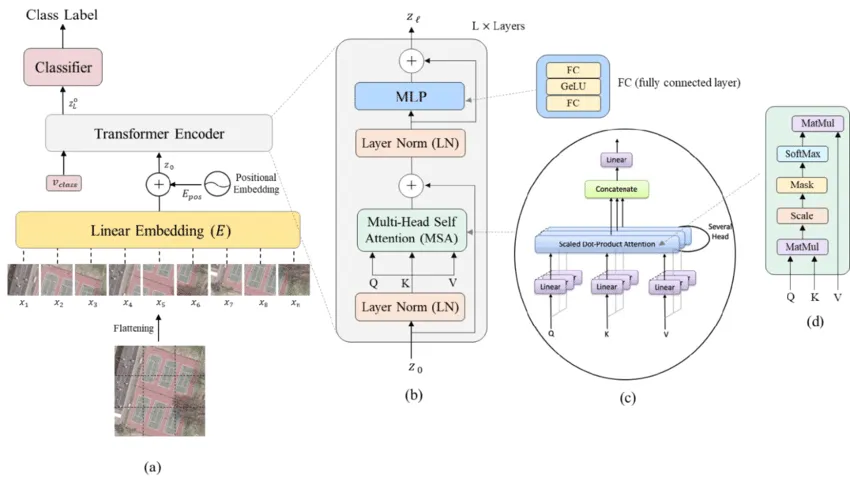

In [15]:
Image("arch-2.webp")

### Diagram explanation

As seen in (a) the image is chopped up into sub-images, which are fed into a linear embedding; each sub-image becomes a one-dimensional vector.
We add positional embeddings (tokens) to the vector; they are eant to allow the network to know where each sub-image was originally placed in the image. Next we feed the resulting sequence into a standard Transformer encoder.

Transformer blocks are composed of the Layer normalization, Multi-head self-Attention and a residual connection. Then a second LN and a Multi-Layer Perceptron and again a residual connection.

To perform the classification, we add a learnable **classification token** to the sequence.


## Patchifying and the linear mapping

Our input as size (N,1,28,28) and we want to reshape it into (N, #Patches, Patch dimensionality)

In our example we break each (1,28,28) into 7x7 patches (4x4 each) -> we get 49 sub-images per image

Meaning we reshape the input to (N, 49,16)

-> create the patchifying method operation

n is the number of images (batch size),

c is the number of channels (e.g., 1 for grayscale, 3 for RGB),

h is the height of each image,

w is the width of each image.

iterates over each image in the batch. idx is the index of the image, and image is the actual image tensor.


patches = torch.zeros(n,n_patches **2, h*w*C // .. 
-> For each image in the batch, there will be n_patches^2 flattened patches.



In [7]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    #since applied to square images only:
    assert h == w
    patches = torch.zeros(n,n_patches **2,h*w*c//n_patches **2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            patch = image[:, i * patch_size:( i + 1 ) * patch_size,j * patch_size: (i+j) * patch_size]
            patches[idx, i * n_patches + j] = patch.flatten()
    return patches
    


Outer Loop (for i): Iterates over each position in the sequence.


Inner Loop (for j): Iterates over each dimension of the embedding.



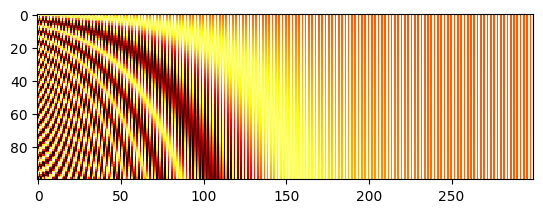

In [9]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()